## <font color='darkblue'>Preface</font>
([article source](https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/)) <b><font size='3ptx'>A standard deep learning model for [text classification](https://machinelearningmastery.com/best-practices-document-classification-deep-learning/) and [sentiment analysis](https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/) uses a word embedding layer and one-dimensional convolutional neural network.</font></b>

The model can be expanded by using multiple parallel convolutional neural networks that read the source document using different kernel sizes. This, in effect, <b>creates a multichannel convolutional neural network for text that reads text with different n-gram sizes</b> (<font color='brown'>groups of words</font>).

<b>In this tutorial, you will discover how to develop a multichannel convolutional neural network for sentiment prediction on text movie review data.</b>

After completing this tutorial, you will know:
* How to prepare movie review text data for modeling.
* How to develop a multichannel convolutional neural network for text in Keras.
* How to evaluate a fit model on unseen movie review data.

### <font color='darkgreen'>Tutorial Overview</font>
This tutorial is divided into 4 parts; they are:
* <b><font size='3ptx'><a href='#sect1'>Movie Review Dataset</a></font></b>
* <b><font size='3ptx'><a href='#sect2'>Data Preparation</a></font></b>
* <b><font size='3ptx'><a href='#sect3'>Develop Multichannel Model</a></font></b>
* <b><font size='3ptx'><a href='#sect4'>Evaluate Model</a></font></b>

<a id='sect1'></a>
## <font color='darkblue'>Movie Review Dataset</font>
The Movie Review Data is a collection of movie reviews retrieved from the imdb.com website in the early 2000s by Bo Pang and Lillian Lee. The reviews were collected and made available as part of their research on natural language processing.

The reviews were originally released in 2002, but an updated and cleaned up version was released in 2004, referred to as “v2.0”.

The dataset is comprised of 1,000 positive and 1,000 negative movie reviews drawn from an archive of the rec.arts.movies.reviews newsgroup hosted at imdb.com. The authors refer to this dataset as the “polarity dataset.”
> Our data contains 1000 positive and 1000 negative reviews all written before 2002, with a cap of 20 reviews per author (312 authors total) per category. We refer to this corpus as the polarity dataset.
> <br/><br/>
> — [A Sentimental Education: Sentiment Analysis Using Subjectivity Summarization Based on Minimum Cuts, 2004.](http://xxx.lanl.gov/abs/cs/0409058)

<br/>

The data has been cleaned up somewhat; for example:
* The dataset is comprised of only English reviews.
* All text has been converted to lowercase.
* There is white space around punctuation like periods, commas, and brackets.
* Text has been split into one sentence per line.
<br/>

The data has been used for a few related natural language processing tasks. For classification, the performance of machine learning models (<font color='brown'>such as Support Vector Machines</font>) on the data is in the range of high 70% to low 80% (<font color='brown'>e.g. 78%-82%</font>).

<b>More sophisticated data preparation may see results as high as 86% with 10-fold cross-validation</b>. This gives us a ballpark of low-to-mid 80s if we were looking to use this dataset in experiments of modern methods.
> … depending on choice of downstream polarity classifier, we can achieve highly statistically significant improvement (from 82.8% to 86.4%)
> <br/><br/>
> — [A Sentimental Education: Sentiment Analysis Using Subjectivity Summarization Based on Minimum Cuts, 2004.](http://xxx.lanl.gov/abs/cs/0409058)

<br/>

You can download the dataset from here:
* [Movie Review Polarity Dataset (review_polarity.tar.gz, 3MB)](https://raw.githubusercontent.com/jbrownlee/Datasets/master/review_polarity.tar.gz)

After unzipping the file, you will have a directory called “txt_sentoken” with two sub-directories containing the text “neg” and “pos” for negative and positive reviews. Reviews are stored one per file with a naming convention `cv000` to `cv999` for each neg and pos.

Next, let’s look at loading and preparing the text data.

<a id='sect2'></a>
## <font color='darkblue'>Data Preparation</font>
In this section, we will look at 3 things:
1. <b><a href='#sect2_1'>Separation of data into training and test sets.</a></b>
2. <b><a href='#sect2_2'>Loading and cleaning the data to remove punctuation and numbers.</a></b>
3. <b><a href='#sect2_3'>Prepare all reviews and save to file.</a></b>

In [1]:
from nltk.corpus import stopwords

import string
import os
from pickle import dump, load

In [2]:
DATA_SOURCE_PATH = '../../datas/review_ploarity/txt_sentoken/'
POS_DATA_SOURCE_PATH = os.path.join(DATA_SOURCE_PATH, 'pos')
NEG_DATA_SOURCE_PATH = os.path.join(DATA_SOURCE_PATH, 'neg')

<a id='sect2_1'></a>
### <font color='darkgreen'>Split into Train and Test Sets</font>
<b>We are pretending that we are developing a system that can predict the sentiment of a textual movie review as either positive or negative.</b>

This means that after the model is developed, we will need to make predictions on new textual reviews. This will require all of the same data preparation to be performed on those new reviews as is performed on the training data for the model.

We will ensure that this constraint is built into the evaluation of our models by splitting the training and test datasets prior to any data preparation. This means that any knowledge in the data in the test set that could help us better prepare the data (<font color='brown'>e.g. the words used</font>) is unavailable in the preparation of data used for training the model.

That being said, we will use the last 100 positive reviews and the last 100 negative reviews as a test set (<font color='brown'>100 reviews</font>) and the remaining 1,800 reviews as the training dataset. <b>This is a 90% train, 10% split of the data.</b>

The split can be imposed easily by using the filenames of the reviews where reviews named 000 to 899 are for training data and reviews named 900 onwards are for test.

<a id='sect2_2'></a>
### <font color='darkgreen'>Loading and Cleaning Reviews</font>
<b>The text data is already pretty clean; not much preparation is required.</b>

Without getting bogged down too much by the details, we will prepare the data in the following way:
* Split tokens on white space.
* Remove all punctuation from words.
* Remove all words that are not purely comprised of alphabetical characters.
* Remove all words that are known stop words.
* Remove all words that have a length <= 1 character.

We can put all of these steps into a function called <font color='blue'>clean_doc()</font> that takes as an argument the raw text loaded from a file and returns a list of cleaned tokens. We can also define a function <font color='blue'>load_doc()</font> that loads a document from file ready for use with the <font color='blue'>clean_doc()</font> function. An example of cleaning the first positive review is listed below.

In [3]:
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text
 
# turn a doc into clean tokens
def clean_doc(doc):
  # split into tokens by white space
  tokens = doc.split()
  # remove punctuation from each token
  table = str.maketrans('', '', string.punctuation)
  tokens = [w.translate(table) for w in tokens]
  # remove remaining tokens that are not alphabetic
  tokens = [word for word in tokens if word.isalpha()]
  # filter out stop words
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]
  # filter out short tokens
  tokens = [word for word in tokens if len(word) > 1]
  return tokens

In [4]:
# load the document
filename = os.path.join(DATA_SOURCE_PATH, 'pos/cv000_29590.txt')
text = load_doc(filename)
tokens = clean_doc(text)
print(tokens[:20])

['films', 'adapted', 'comic', 'books', 'plenty', 'success', 'whether', 'theyre', 'superheroes', 'batman', 'superman', 'spawn', 'geared', 'toward', 'kids', 'casper', 'arthouse', 'crowd', 'ghost', 'world']


Running the example loads and cleans one movie review.

<a id='sect2_3'></a>
### <font color='darkgreen'>Clean All Reviews and Save</font>
<b>We can now use the function to clean reviews and apply it to all reviews.</b>

To do this, we will develop a new function named <font color='blue'>process_docs()</font> below that will walk through all reviews in a directory, clean them, and return them as a list.

We will also add an argument to the function to indicate whether the function is processing train or test reviews, that way the filenames can be filtered (<font color='brown'>as described above</font>) and only those train or test reviews requested will be cleaned and returned.

The full function is listed below.

In [5]:
def process_docs(directory, is_trian):
  documents = list()
  # walk through all files in the folder
  for filename in os.listdir(directory):
    # skip any reviews in the test set
    if is_trian and filename.startswith('cv9'):
      continue
    if not is_trian and not filename.startswith('cv9'):
      continue
      
    # create the full path of the file to open
    path = directory + '/' + filename
    # load the doc
    doc = load_doc(path)
    # clean doc
    tokens = clean_doc(doc)
    # add to list
    documents.append(tokens)
    
  return documents

We can call this function with negative training reviews as follows:

In [6]:
negative_docs = process_docs(NEG_DATA_SOURCE_PATH, True)

Next, we need labels for the train and test documents. We know that we have 900 training documents and 100 test documents. We can use a Python list comprehension to create the <b>labels for the negative (0) and positive (1) reviews for both train and test sets.</b>

In [7]:
train_y = [0 for _ in range(900)] + [1 for _ in range(900)]
test_y = [0 for _ in range(100)] + [1 for _ in range(100)]

Finally, we want to save the prepared train and test sets to file so that we can load them later for modeling and model evaluation.

The function below-named <font color='blue'>save_dataset()</font> will save a given prepared dataset (<font color='brown'>`X` and `y` elements</font>) to a file using the pickle API.

In [8]:
# save a dataset to file
def save_dataset(dataset, filename):
  dump(dataset, open(filename, 'wb'))
  print('Saved: %s' % filename)

Now we are ready to dump both training and testing dataset:

In [9]:
# load all training reviews
negative_docs = process_docs(NEG_DATA_SOURCE_PATH, True)
positive_docs = process_docs(POS_DATA_SOURCE_PATH, True)
train_X = negative_docs + positive_docs
train_y = [0 for _ in range(900)] + [1 for _ in range(900)]
save_dataset([train_X, train_y], 'train.pkl')
 
# load all test reviews
negative_docs = process_docs(NEG_DATA_SOURCE_PATH, False)
positive_docs = process_docs(POS_DATA_SOURCE_PATH, False)
test_X = negative_docs + positive_docs
test_y = [0 for _ in range(100)] + [1 for _ in range(100)]
save_dataset([test_X, test_y], 'test.pkl')

Saved: train.pkl
Saved: test.pkl


Now we are ready to develop our model.

<a id='sect3'></a>
## <font color='darkblue'>Develop Multichannel Model</font>
<b><font size='3ptx'>In this section, we will develop a multichannel convolutional neural network for the sentiment analysis prediction problem.</font></b>

This section is divided into 3 parts:
* <b><a href='#sect3_1'>Encode Data</a></b>
* <b><a href='#sect3_2'>Define Model.</a></b>
* <b><a href='#sect3_3'>Complete Example.</a></b>

In [36]:
from numpy import array
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
#from keras.layers.merge import concatenate
from keras.layers import concatenate
from keras.models import load_model

import matplotlib.pyplot as plt

<a id='sect3_1'></a>
### <font color='darkgreen'>Encode Data</font>
<b>The first step is to load the cleaned training dataset.</b>

The function below-named <font color='blue'>load_dataset()</font> can be called to load the pickled training dataset.

In [11]:
# load a clean dataset
def load_dataset(filename):
  return load(open(filename, 'rb'))
 
trainLines, trainLabels = load_dataset('train.pkl')

Next, we must fit a [**Keras Tokenizer**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) on the training dataset. We will use this tokenizer to both define the vocabulary for the [**Embedding layer**](https://machinelearningmastery.com/what-are-word-embeddings/) and encode the review documents as integers.

The function <font color='blue'>create_tokenizer()</font> below will create a [**Tokenizer**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) given a list of documents.

In [12]:
# fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

We also need to know the maximum length of input sequences as input for the model and to <b>pad all sequences to the fixed length.</b>

The function <font color='blue'>max_length()</font> below will calculate the maximum length (<font color='brown'>number of words</font>) for all reviews in the training dataset.

In [19]:
# calculate the maximum document length
def max_length(tokens_list):
  return max([len(tokens) for tokens in tokens_list])

We also need to know the size of the vocabulary for the [**Embedding layer**](https://machinelearningmastery.com/what-are-word-embeddings/). This can be calculated from the prepared [**Tokenizer**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer), as follows:
```python
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
```

<br/>

Finally, we can integer encode and pad the clean movie review text. The function below named <font color='blue'>encode_text()</font> will both encode and pad text data to the maximum review length:
* [tf.keras.utils.pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences): Pads sequences to the same length.

In [14]:
# encode a list of lines
def encode_text(tokenizer, lines, length):
  # integer encode
  encoded = tokenizer.texts_to_sequences(lines)
  # pad encoded sequences
  padded = pad_sequences(encoded, maxlen=length, padding='post')
  return padded

<a id='sect3_2'></a>
### <font color='darkgreen'>Define Model</font>
<b>A standard model for document classification is to use an Embedding layer as input, followed by a one-dimensional convolutional neural network, pooling layer, and then a prediction output layer.</b>

The kernel size in the [**convolutional layer**](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/) defines the number of words to consider as the convolution is passed across the input text document, providing a grouping parameter.

A multi-channel convolutional neural network for document classification involves using multiple versions of the standard model with different sized kernels. <b>This allows the document to be processed at different resolutions or different n-grams</b> (<font color='brown'>groups of words</font>) <b>at a time, whilst the model learns how to best integrate these interpretations</b>.

This approach was first described by Yoon Kim in his 2014 paper titled “[Convolutional Neural Networks for Sentence Classification.](https://arxiv.org/abs/1408.5882)”

In the paper, Kim experimented with static and dynamic (<font color='brown'>updated</font>) embedding layers, <b>we can simplify the approach and instead focus only on the use of different kernel sizes</b>. This approach is best understood with a diagram taken from Kim’s paper:
![Depiction of the multiple-channel convolutional neural network for text.
Taken from “Convolutional Neural Networks for Sentence Classification.”](images/1.PNG)

<br/>

In Keras, a multiple-input model can be defined using the [functional API](https://keras.io/getting-started/functional-api-guide/). <b>We will define a model with three input channels for processing 4-grams, 6-grams, and 8-grams of movie review text.</b>

Each channel is comprised of the following elements:
* **Input layer** that defines the length of input sequences.
* **Embedding layer** set to the size of the vocabulary and 100-dimensional real-valued representations.
* **One-dimensional convolutional layer** with 32 filters and a kernel size set to the number of words to read at once.
* **Max Pooling layer** to consolidate the output from the convolutional layer.
* **Flatten layer** to reduce the three-dimensional output to two dimensional for concatenation.

<br/>

The output from the three channels are concatenated into a single vector and process by a Dense layer and an output layer.

The function below defines and returns the model. As part of defining the model, a summary of the defined model is printed and a plot of the model graph is created and saved to file.

In [39]:
# define the model
def define_model(length: int, vocab_size: int):
  '''Defines the model.
  
  Args:
    length: Max document sentence length.
    vocab_size: Vocabulary size.
    
  Returns:
    The defined model.
  '''
  # channel 1
  inputs1 = Input(shape=(length,))
  embedding1 = Embedding(vocab_size, 100)(inputs1)
  conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
  drop1 = Dropout(0.1)(conv1)
  pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)

  # channel 2
  inputs2 = Input(shape=(length,))
  embedding2 = Embedding(vocab_size, 100)(inputs2)
  conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
  drop2 = Dropout(0.1)(conv2)
  pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)

  # channel 3
  inputs3 = Input(shape=(length,))
  embedding3 = Embedding(vocab_size, 100)(inputs3)
  conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
  drop3 = Dropout(0.5)(conv3)
  pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)

  # merge
  merged = concatenate([flat1, flat2, flat3])
  
  # interpretation
  dense1 = Dense(20, activation='relu')(merged)
  dense1 = Dense(10, activation='relu')(merged)
  outputs = Dense(1, activation='sigmoid')(dense1)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)

  # compile
  model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

  # summarize
  print(model.summary())
  plot_model(model, show_shapes=True, to_file='multichannel.png')
  return model

<a id='sect3_3'></a>
### <font color='darkgreen'>Complete Example</font>
Pulling all of this together, the complete example is listed below:

In [40]:
# load training dataset
train_lines, train_labels = load_dataset('train.pkl')

# create tokenizer
tokenizer = create_tokenizer(train_lines)

# calculate max document length
length = max_length(train_lines)

# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)

# encode data
train_X = encode_text(tokenizer, train_lines, length)
print(train_X.shape)

# define model
model = define_model(length, vocab_size)

Max document length: 1380
Vocabulary size: 44277
(1800, 1380)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 1380)]       0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 1380)]       0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 1380)]       0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 1380, 100)    4427700     ['input_10[0][0]']               
                              

A plot of the defined model is saved to file, clearly showing the three input channels for the model:
![Plot of the Multichannel Convolutional Neural Network For Text](images/2.PNG)

In [41]:
%%time
# fit model
history = model.fit(
  [train_X, train_X, train_X],
  array(train_labels), epochs=15, batch_size=16,
  validation_split=0.1)

# save the model
model.save('model.h5')

Epoch 1/15
102/102 [==============================] - 25s 233ms/step - loss: 0.6892 - accuracy: 0.5679 - val_loss: 0.8141 - val_accuracy: 0.2778
Epoch 2/15
102/102 [==============================] - 23s 228ms/step - loss: 0.2162 - accuracy: 0.9432 - val_loss: 0.1777 - val_accuracy: 0.9556
Epoch 3/15
102/102 [==============================] - 23s 228ms/step - loss: 0.0046 - accuracy: 0.9994 - val_loss: 0.5968 - val_accuracy: 0.6722
Epoch 4/15
102/102 [==============================] - 23s 228ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.5783 - val_accuracy: 0.6778
Epoch 5/15
102/102 [==============================] - 23s 227ms/step - loss: 5.8682e-04 - accuracy: 1.0000 - val_loss: 0.6871 - val_accuracy: 0.6556
Epoch 6/15
102/102 [==============================] - 23s 224ms/step - loss: 3.6168e-04 - accuracy: 1.0000 - val_loss: 0.6209 - val_accuracy: 0.6722
Epoch 7/15
102/102 [==============================] - 23s 224ms/step - loss: 2.5182e-04 - accuracy: 1.0000 - val_loss: 0.5

The function <font color='blue'>draw_history_chart</font> helps us to illustrate the training history:

In [42]:
def draw_history_chart(history):
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

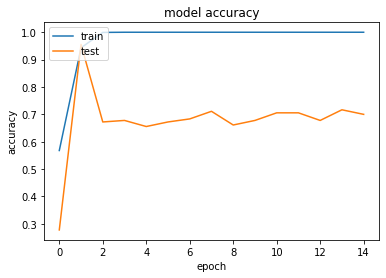

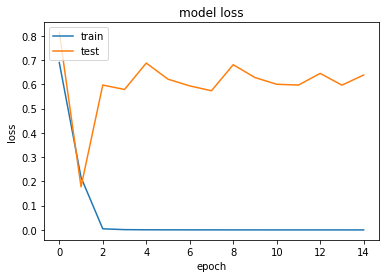

In [43]:
draw_history_chart(history)

Running the example first prints a summary of the prepared training dataset. The model is fit for a number of epochs and saved to the file <font color='olive'>`model.h5`</font> for later evaluation.

<a id='sect4'></a>
## <font color='darkblue'>Evaluate Model</font>
<b><font size='3ptx'>In this section, we can evaluate the fit model by predicting the sentiment on all reviews in the unseen test dataset.</font></b>

Using the data loading functions developed in the previous section, we can load and encode both the training and test datasets.

In [44]:
# load datasets
test_lines, test_labels = load_dataset('test.pkl')

# encode data
test_X = encode_text(tokenizer, test_lines, length)
print(test_X.shape)

(200, 1380)


We can load the saved model and evaluate it on both the training and test datasets.

The complete example is listed below:

In [24]:
test_predict = model.predict([test_X, test_X, test_X])

7/7 [==============================] - 1s 45ms/step


In [26]:
# The prediction output is numeric. We have to translate them into label (0, 1) # 1 as positive
test_predict[:3]

array([[0.00053977],
       [0.00209122],
       [0.00035753]], dtype=float32)

In [45]:
# load the model
model = load_model('model.h5')
 
# evaluate model on training dataset
loss, acc = model.evaluate([train_X, train_X, train_X], array(train_labels), verbose=0)
print('Train Accuracy: %f' % (acc*100))
 
# evaluate model on test dataset dataset
loss, acc = model.evaluate([test_X, test_X, test_X], array(test_labels), verbose=0)
print('Test Accuracy: %f' % (acc*100))

Train Accuracy: 97.000003
Test Accuracy: 83.499998


Running the example prints the skill of the model on both the training and test datasets.

We can see that, as expected, the skill on the training dataset is excellent, here at 100% accuracy. We can also see that the skill of the model on the unseen test dataset is also very impressive, achieving 83.5%, which is not bad according to past performance data (<font color='brown'>although not a direct apples-to-apples comparison</font>).

## <font color='darkblue'>Extensions</font>
This section lists some ideas for extending the tutorial that you may wish to explore:
* **Different n-grams**. Explore the model by changing the kernel size (<font color='brown'>number of n-grams</font>) used by the channels in the model to see how it impacts model skill.
* **More or Fewer Channels**. Explore using more or fewer channels in the model and see how it impacts model skill.
* **Deeper Network**. Convolutional neural networks perform better in computer vision when they are deeper. Explore using deeper models here and see how it impacts model skill.

### <font color='darkgreen'>Further Reading</font>
This section provides more resources on the topic if you are looking to go deeper.
* [Convolutional Neural Networks for Sentence Classification, 2014.](https://arxiv.org/abs/1408.5882)
* [Convolutional Neural Networks for Sentence Classification (code).](https://github.com/yoonkim/CNN_sentence)
* [Keras Functional API](https://keras.io/getting-started/functional-api-guide/)
* [Display Deep Learning Model Training History in Keras](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/)